# Project milestone 2 

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import json
from wordcloud import WordCloud, STOPWORDS
import gzip
from pylab import xticks
import tqdm.notebook 
from tqdm.notebook import trange

In [99]:
data_folder_CMU = './data/MovieSummaries/'
data_folder_IMDB = './IMDb data/'

In [100]:
import warnings
warnings.filterwarnings('ignore')

In [101]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

## 1. Contextual analysis of the datasets used

#### Movie metadata CMU dataset

In [102]:
cmu_movie_metadata = pd.read_csv(data_folder_CMU + 'movie.metadata.tsv', sep ="\t", header=None
                      , names = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name'
                       ,'Movie release date','Movie box office revenue','Movie runtime',
                       'Movie languages', 'Movie countries','Movie genres'], index_col = 'Wikipedia movie ID')

cmu_movie_metadata.head(5)

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


##### Most frequent words in titles

Let's print the most recurrent words in the movie names :

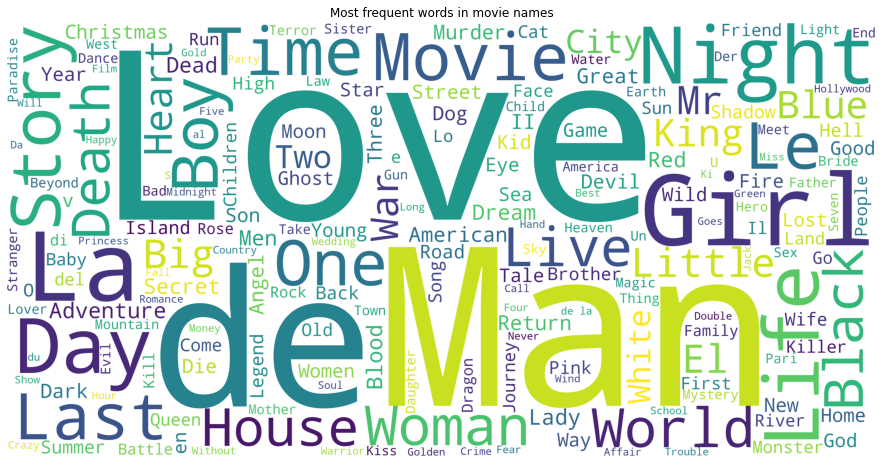

In [6]:
wordcloud_df = cmu_movie_metadata.copy()
wordcloud_df['Movie name'] = wordcloud_df['Movie name'].astype('str')
title_corpus = ' '.join(wordcloud_df['Movie name'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most frequent words in movie names')
plt.show()

##### Number of movies per year

In [7]:
print('There are {} different movies in this dataset'.format(len(cmu_movie_metadata)))

There are 81741 different movies in this dataset


Let's see from what years come the movies in our dataset :

Text(0.5, 1.0, 'Number of movies released per year')

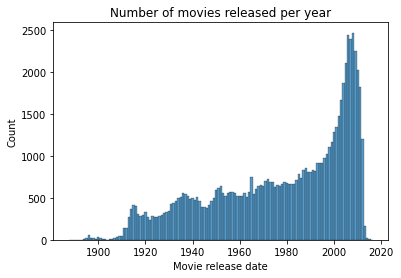

In [6]:
cmu_movie_metadata["Movie release date"] = pd.to_datetime(cmu_movie_metadata["Movie release date"],errors = 'coerce', utc = True).dt.year
sns.histplot(cmu_movie_metadata['Movie release date'], discrete = True)
plt.title('Number of movies released per year')

We observe that the number of movies released each year (present in the dataset) increases in a linear way between 1920s and 1995. And then the increase in number of movies per year is exponential.

##### Genres, languages, and countries of the movies in the dataset

In [7]:
cmu_movie_metadata['Movie languages'] = cmu_movie_metadata['Movie languages'].apply(lambda x: json.loads(x)) 
cmu_movie_metadata['Movie languages'] = cmu_movie_metadata['Movie languages'].apply(lambda x: list(x.values()))
cmu_movie_metadata['Movie countries'] = cmu_movie_metadata['Movie countries'].apply(lambda x: json.loads(x)) 
cmu_movie_metadata['Movie countries'] = cmu_movie_metadata['Movie countries'].apply(lambda x: list(x.values()))
cmu_movie_metadata['Movie genres'] = cmu_movie_metadata['Movie genres'].apply(lambda x: json.loads(x)) 
cmu_movie_metadata['Movie genres'] = cmu_movie_metadata['Movie genres'].apply(lambda x: list(x.values()))

In [103]:
languages_dict = {}
for i in cmu_movie_metadata['Movie languages']:
    for j in i:
        if j not in languages_dict:
            languages_dict[j] = 1
        else:
            languages_dict[j] += 1
            
countries_dict = {}
for i in cmu_movie_metadata['Movie countries']:
    for j in i:
        if j not in countries_dict:
            countries_dict[j] = 1
        else:
            countries_dict[j] += 1     
            
genres_dict = {}
for i in cmu_movie_metadata['Movie genres']:
    for j in i:
        if j not in genres_dict:
            genres_dict[j] = 1
        else:
            genres_dict[j] += 1

            
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

Text(0.5, 0, '')

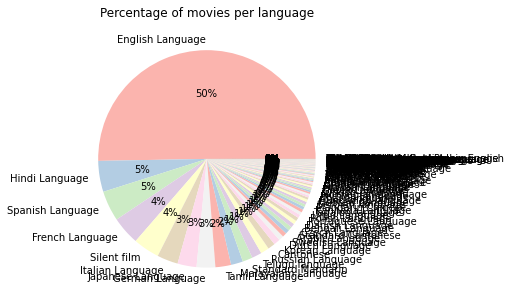

In [9]:
# Distribution of the 10 genres (pie chart in cute colors)
cmap = plt.get_cmap('Pastel1')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

to_1D(cmu_movie_metadata['Movie languages']).value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', figsize=(5, 5), colors=colors)
plt.title('Percentage of movies per language')
plt.ylabel('')
plt.xlabel('')

Text(0.5, 0, '')

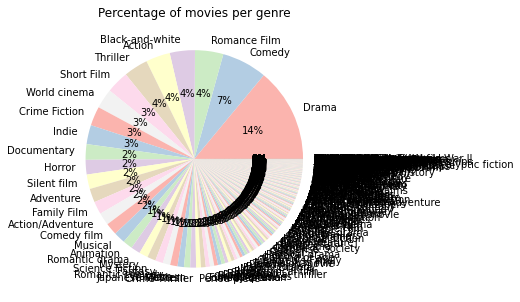

In [10]:
to_1D(cmu_movie_metadata['Movie genres']).value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', figsize=(5, 5), colors=colors)
plt.title('Percentage of movies per genre')
plt.ylabel('')
plt.xlabel('')

Text(0.5, 0, '')

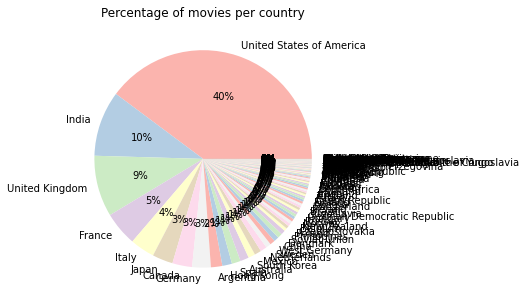

In [11]:
to_1D(cmu_movie_metadata['Movie countries']).value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', figsize=(5, 5), colors=colors)
plt.title('Percentage of movies per country')
plt.ylabel('')
plt.xlabel('')

#### Character metadata CMU dataset

In [12]:
char_metadata = pd.read_csv(data_folder_CMU + 'character.metadata.tsv', sep ="\t", header=None
                      , names = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date'
                       ,'Character name','Actor date of birth','Actor gender',
                       'Actor height', 'Actor ethnicity','Actor name','Actor age at movie release',
                        'Freebase character/actor map ID', 'Freebase character ID',
                        'Freebase actor ID'], index_col = 'Wikipedia movie ID')

char_metadata.head(3)

,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
Wikipedia movie ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l


##### Percentage of women/men actors in the dataset

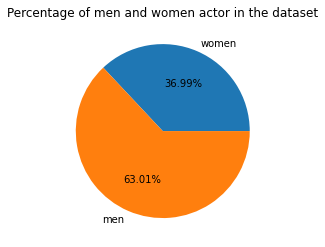

In [13]:
df_fem = char_metadata[char_metadata['Actor gender'] == 'F']
df_masc = char_metadata[char_metadata['Actor gender'] == 'M']
mylabels = ["women", "men"]
plt.pie(np.array([df_fem['Actor name'].nunique(),df_masc['Actor name'].nunique()]), labels = mylabels, autopct='%1.2f%%')
plt.title("Percentage of men and women actor in the dataset")
plt.show()

##### Ethnicities

In [16]:
# loading queried look-up table for mapping ethnicities and freebase-IDs
ethnic_df = pd.read_csv('./Freebase_ids/' + 'ethnic_group_query.csv')
ethnic_df.rename(columns = {'freebaseID':'Actor ethnicity'}, inplace = True)
merged_df = char_metadata.merge(ethnic_df, how = 'left', on = 'Actor ethnicity')

FileNotFoundError: [Errno 2] No such file or directory: './Freebase_ids/ethnic_group_query.csv'

In [19]:
df_no_dup = merged_df.drop_duplicates(subset = 'Freebase actor ID')

NameError: name 'merged_df' is not defined

In [ ]:
d = df_no_dup['name'].value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', figsize=(5, 5), colors=colors)
plt.title('Percentage of actors of each ethnicity')
plt.ylabel('')
plt.xlabel('')

#### IMDb dataset

In [14]:
f = gzip.open(data_folder_IMDB + './title.principals.tsv.gz','rb')
df_titles_principal = pd.read_csv(f, sep='\t')
df_titles_principal.head(5)

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [15]:
df_titles_principal['category'].unique()

array(['self', 'director', 'cinematographer', 'composer', 'producer',
       'editor', 'actor', 'actress', 'writer', 'production_designer',
       'archive_footage', 'archive_sound'], dtype=object)

In [16]:
f=gzip.open(data_folder_IMDB + './name.basics.tsv.gz','rb')
df_name_basics = pd.read_csv(f, sep='\t')
df_name_basics.head(5)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0050419,tt0072308,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0038355,tt0117057,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0056404,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0080455,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0083922"


In [17]:
df_principal_actors = df_titles_principal[df_titles_principal['category'].str.contains('actress|actor')]
df_merged = df_principal_actors.merge(df_name_basics, how='left', on='nconst')
df_merged = df_merged.drop(columns = ['birthYear', 'deathYear', 'knownForTitles', 'primaryProfession' ])
df_merged.head(5)

,tconst,ordering,nconst,category,job,characters,primaryName
0,tt0000005,1,nm0443482,actor,\N,"[""Blacksmith""]",Charles Kayser
1,tt0000005,2,nm0653042,actor,\N,"[""Assistant""]",John Ott
2,tt0000007,1,nm0179163,actor,\N,\N,James J. Corbett
3,tt0000007,2,nm0183947,actor,\N,\N,Peter Courtney
4,tt0000008,1,nm0653028,actor,\N,"[""Sneezing Man""]",Fred Ott


In [18]:
f = gzip.open(data_folder_IMDB + '/title.basics.tsv.gz', 'rb')
df_title_basics =  pd.read_csv(f, sep='\t')
df_title_basics.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [19]:
print("There are {} titles in the IMDb dataset".format(len(df_title_basics)))

There are 9363390 titles in the IMDb dataset


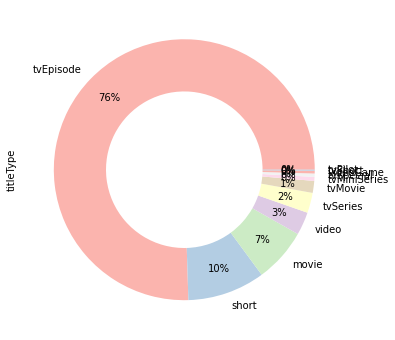

In [20]:
cmap = plt.get_cmap('Pastel1')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
df_title_basics.titleType.value_counts().plot.pie(autopct="%.0f%%",figsize=(6,6),pctdistance=0.8,
                                                 wedgeprops=dict(width=0.4), colors = colors)
plt.show()

Let's focus only on IMDb movies

In [21]:
df_movie_basics = df_title_basics[df_title_basics['titleType'] == 'movie']
print("There are {} movies in the IMDb dataset".format(len(df_movie_basics)))

There are 626772 movies in the IMDb dataset


In [22]:
df_movie_basics.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


In [23]:
final_df = df_merged.merge(df_movie_basics, how='left', on='tconst')
final_df.head(5)

,tconst,ordering,nconst,category,job,characters,primaryName,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000005,1,nm0443482,actor,\N,"[""Blacksmith""]",Charles Kayser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0000005,2,nm0653042,actor,\N,"[""Assistant""]",John Ott,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0000007,1,nm0179163,actor,\N,\N,James J. Corbett,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0000007,2,nm0183947,actor,\N,\N,Peter Courtney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0000008,1,nm0653028,actor,\N,"[""Sneezing Man""]",Fred Ott,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
final_df = final_df.dropna(subset = ['primaryTitle'])
final_df = final_df.drop(columns = ['isAdult', 'endYear', 'titleType', 'job', 'originalTitle'])

In [25]:
final_df.head(5)

,tconst,ordering,nconst,category,characters,primaryName,primaryTitle,startYear,runtimeMinutes,genres
5,tt0000009,1,nm0063086,actress,"[""Miss Geraldine Holbrook (Miss Jerry)""]",Blanche Bayliss,Miss Jerry,1894,45,Romance
6,tt0000009,2,nm0183823,actor,"[""Mr. Hamilton""]",William Courtenay,Miss Jerry,1894,45,Romance
7,tt0000009,3,nm1309758,actor,"[""Chauncey Depew - the Director of the New Yor...",Chauncey Depew,Miss Jerry,1894,45,Romance
231,tt0000502,1,nm0215752,actor,\N,Antonio del Pozo,Bohemios,1905,100,\N
232,tt0000502,2,nm0252720,actor,\N,El Mochuelo,Bohemios,1905,100,\N


In [105]:
print(len(final_df[final_df['category'] == 'actress']))
print(len(final_df[final_df['category'] == 'actor']))


736752
1211788


In [133]:
women_ordering = final_df[final_df['category'] == 'actress']
men_ordering = final_df[final_df['category'] == 'actor']
women_ordering = women_ordering[women_ordering['startYear'] >= '1950']
men_ordering = men_ordering[men_ordering['startYear'] >= '1950']
women_ordering = women_ordering[women_ordering['startYear'] <= '2015']
men_ordering = men_ordering[men_ordering['startYear'] <= '2015']
women_ordering = women_ordering[women_ordering['ordering'] <= 3]
men_ordering = men_ordering[men_ordering['ordering'] <= 3].sample(n=len(women_ordering))

idxmen = men_ordering.groupby('tconst')['ordering'].idxmin()
idxwomen = women_ordering.groupby('tconst')['ordering'].idxmin()
# Use the index to filter the dataframe
filtered_df_men = men_ordering.loc[idxmen]
filtered_df_women = women_ordering.loc[idxwomen]

In [128]:
len(filtered_df_men)

205492

In [129]:
len(filtered_df_women)

210769

In [130]:
len(women_ordering)/(len(women_ordering)+len(men_ordering))

0.5

In [134]:
women_groups = filtered_df_women.groupby(['startYear'], as_index = False)
men_groups = filtered_df_men.groupby(['startYear'], as_index = False)

men_groups = men_groups.apply(lambda x: pd.Series({
    'mean order' : x['ordering'].mean(),
    'lower_err_order': bootstrap_CI(x['ordering'], 100)[0],
    'upper_err_order': bootstrap_CI(x['ordering'], 100)[1]
}))

women_groups = women_groups.apply(lambda x: pd.Series({
    'mean order' : x['ordering'].mean(),
    'lower_err_order': bootstrap_CI(x['ordering'], 100)[0],
    'upper_err_order': bootstrap_CI(x['ordering'], 100)[1]
}))


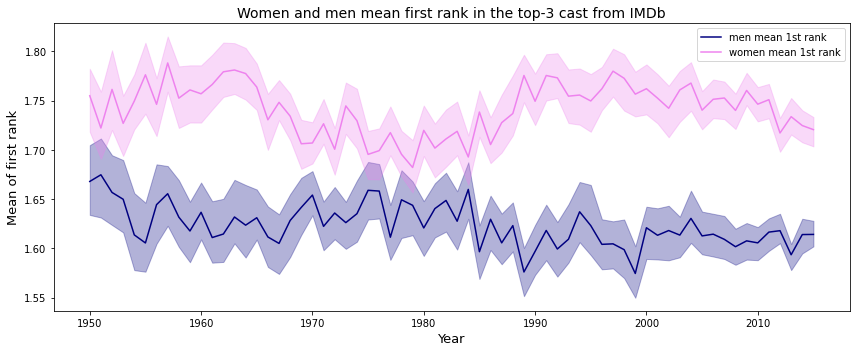

In [163]:
fig, ax = plt.subplots(figsize=(12,5), tight_layout=True)
ax.plot( ["%s" % item for item in men_groups.startYear.to_list()], men_groups['mean order'], label = 'men mean 1st rank', color = 'navy')
ax.fill_between(["%s" % item for item in men_groups.startYear.to_list()], men_groups.lower_err_order,
                 men_groups.upper_err_order, alpha = 0.3, color = 'navy')
ax.plot( ["%s" % item for item in women_groups.startYear.to_list()], women_groups['mean order'], label = 'women mean 1st rank', color = 'violet')
ax.fill_between(["%s" % item for item in men_groups.startYear.to_list()], women_groups.lower_err_order,
                 women_groups.upper_err_order, alpha = 0.3, color = 'violet')

xticklabels = ["%s" % item for item in men_groups.startYear.to_list()]
xticks = ax.get_xticks()

# Set the x-tick locations and labels
ax.set_xticks(xticks[::10])
ax.set_xticklabels(xticklabels[::10])

plt.xticks(rotation = 0 )
plt.legend()
plt.xlabel('Year', fontsize = 13)
plt.ylabel('Mean of first rank', fontsize = 13)
plt.title('Women and men mean first rank in the top-3 cast from IMDb', fontsize = 14)
plt.show()

fig.savefig('cast_importance.png', format='jpg', dpi=900, bbox_inches='tight')

As we can see in the above plot, there was a big period between 1965 and 1990 where actresses were ranked before men, with a significant difference. This is no longer the case after these dates. 

In [ ]:
# let's analyze the mean of the position at which the first man and the first woman appears in casts.


In [64]:
# Group the rows by "tconst"
grouped = final_df.groupby("tconst")

# Define a function that checks whether any of the rows in the group have a value of 3 in the "ordering" column
def has_ordering_3(group):
    return group["ordering"].any() == 3

# Apply the function to each group and keep only the groups for which the function returns True
filtered_groups = grouped.apply(has_ordering_3)

# Extract the "tconst" values from the groups
tconst_values = filtered_groups.index.values

# Keep only the rows with the "tconst" values that you want
df_filtered = final_df[final_df["tconst"].isin(tconst_values)]

In [59]:
women_ordering = df_filtered[df_filtered['category'] == 'actress']
men_ordering = df_filtered[df_filtered['category'] == 'actor']
women_ordering = women_ordering[women_ordering['startYear'] >= '1950']
men_ordering = men_ordering[men_ordering['startYear'] >= '1950']
women_ordering = women_ordering[women_ordering['startYear'] <= '2015']
men_ordering = men_ordering[men_ordering['startYear'] <= '2015']
women_ordering = women_ordering[women_ordering['ordering'] <= 3]
men_ordering = men_ordering[men_ordering['ordering'] <= 3]

In [62]:
women_groups = women_ordering.groupby(['startYear'], as_index = False)
men_groups = men_ordering.groupby(['startYear'], as_index = False)


men_groups = men_groups.apply(lambda x: pd.Series({
    'mean order' : x['ordering'].mean(),
    'lower_err_order': bootstrap_CI(x['ordering'], 100)[0],
    'upper_err_order': bootstrap_CI(x['ordering'], 100)[1]
}))

women_groups = women_groups.apply(lambda x: pd.Series({
    'mean order' : x['ordering'].mean(),
    'lower_err_order': bootstrap_CI(x['ordering'], 100)[0],
    'upper_err_order': bootstrap_CI(x['ordering'], 100)[1]
}))


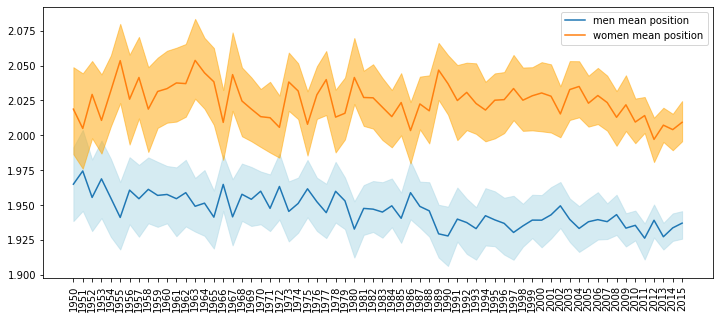

In [63]:
plt.figure(figsize=(12,5))
plt.plot( ["%s" % item for item in men_groups.startYear.to_list()], men_groups['mean order'], label = 'men mean position')
plt.fill_between(["%s" % item for item in men_groups.startYear.to_list()], men_groups.lower_err_order,
                 men_groups.upper_err_order, alpha = 0.5, color = 'lightblue')
plt.plot( ["%s" % item for item in women_groups.startYear.to_list()], women_groups['mean order'], label = 'women mean position')
plt.fill_between(["%s" % item for item in men_groups.startYear.to_list()], women_groups.lower_err_order,
                 women_groups.upper_err_order, alpha = 0.5, color = 'orange')
plt.xticks(rotation = 90 )
plt.legend()      
plt.show()


# IMDb crew

In [12]:
f = gzip.open(data_folder_IMDB + './title.crew.tsv.gz','rb')
df_crew = pd.read_csv(f, sep='\t')
df_crew.head(5)

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


# IMDB Rating female/male analysis

From the dataset provided directly by IMDB, we have the ratings, but not demographic informations of them. By chance, Imdb provides detailed graded by gender and age category which can help us analyse if the ratings are biased towards male opinion or not. Can obtain this data with https://imdbpy.readthedocs.io/en/latest/usage/quickstart.html#sql-bottom.

In [70]:
from imdb import IMDb
ia = IMDb()
m = ia.get_movie('0499549', 'vote details') # The identifier is simply tconst without "tt"
print('median', m.get('median'))
print('arithmetic mean', m.get('arithmetic mean'))
print('number of votes', m.get('number of votes'))
demos = m.get('demographics')
print(m.get('demographics'))

median 8
arithmetic mean 7.8
number of votes {10: 264571, 9: 231205, 8: 305259, 7: 213883, 6: 102507, 5: 48595, 4: 24017, 3: 15169, 2: 10938, 1: 28122}
{'ttrt fltr imdb users': {'votes': 1244266, 'rating': 7.8}, 'ttrt fltr aged under 18': {'votes': 499, 'rating': 7.8}, 'ttrt fltr aged 18 29': {'votes': 174344, 'rating': 7.7}, 'ttrt fltr aged 30 44': {'votes': 571038, 'rating': 7.9}, 'ttrt fltr aged 45 plus': {'votes': 132028, 'rating': 7.9}, 'ttrt fltr males': {'votes': 748852, 'rating': 7.9}, 'ttrt fltr males aged under 18': {'votes': 356, 'rating': 7.8}, 'ttrt fltr males aged 18 29': {'votes': 129351, 'rating': 7.7}, 'ttrt fltr males aged 30 44': {'votes': 462931, 'rating': 7.9}, 'ttrt fltr males aged 45 plus': {'votes': 109461, 'rating': 7.9}, 'ttrt fltr females': {'votes': 171375, 'rating': 7.8}, 'ttrt fltr females aged under 18': {'votes': 103, 'rating': 7.5}, 'ttrt fltr females aged 18 29': {'votes': 39531, 'rating': 7.7}, 'ttrt fltr females aged 30 44': {'votes': 100613, 'rating

Let's put all this in a dataframe

In [106]:
pd.DataFrame.from_dict(m.get('demographics'))

,ttrt fltr imdb users,ttrt fltr aged under 18,ttrt fltr aged 18 29,ttrt fltr aged 30 44,ttrt fltr aged 45 plus,ttrt fltr males,ttrt fltr males aged under 18,ttrt fltr males aged 18 29,ttrt fltr males aged 30 44,ttrt fltr males aged 45 plus,ttrt fltr females,ttrt fltr females aged under 18,ttrt fltr females aged 18 29,ttrt fltr females aged 30 44,ttrt fltr females aged 45 plus,ttrt fltr top 1000 voters,ttrt fltr us users,ttrt fltr non us users
votes,1244266.0,499.0,174344.0,571038.0,132028.0,748852.0,356.0,129351.0,462931.0,109461.0,171375.0,103.0,39531.0,100613.0,20092.0,891.0,272890.0,841398.0
rating,7.8,7.8,7.7,7.9,7.9,7.9,7.8,7.7,7.9,7.9,7.8,7.5,7.7,7.8,8.0,7.5,7.7,7.9


These are the votes for Avatar. In all groups, the grades are quite close : range from 7.5 to 7.9. However, we observe that there are much less votes coming from women tan from men (respectively 748 852 votes coming from men and 171 375 coming from women.

In [72]:
print(ia.search_movie('twilight'))

[<Movie id:1099212[http] title:_Twilight (I) (2008)_>, <Movie id:0955346[http] title:_"Moonlight" (2007)_>, <Movie id:0119594[http] title:_Twilight (1998)_>, <Movie id:0052520[http] title:_"The Twilight Zone" (1959)_>, <Movie id:1673434[http] title:_The Twilight Saga: Breaking Dawn - Part 2 (2012)_>, <Movie id:1324999[http] title:_The Twilight Saga: Breaking Dawn - Part 1 (2011)_>, <Movie id:1325004[http] title:_The Twilight Saga: Eclipse (2010)_>, <Movie id:1259571[http] title:_The Twilight Saga: New Moon (2009)_>, <Movie id:2583620[http] title:_"The Twilight Zone" (2019)_>, <Movie id:0088634[http] title:_"The Twilight Zone" (1985)_>, <Movie id:0086491[http] title:_Twilight Zone: The Movie (1983)_>, <Movie id:0351817[http] title:_The Twilight Samurai (2002)_>, <Movie id:0100732[http] title:_Twilight (1990)_>, <Movie id:0318252[http] title:_"The Twilight Zone" (2002)_>, <Movie id:10625492[http] title:_"Twilight of the Gods" (None)_>, <Movie id:7230370[http] title:_Camp Twilight (2020)_

In [87]:
twilight = ia.get_movie('1099212', 'vote details') # The identifier is simply tconst without "tt"
pd.DataFrame.from_dict(twilight.get('demographics'))

,ttrt fltr imdb users,ttrt fltr aged under 18,ttrt fltr aged 18 29,ttrt fltr aged 30 44,ttrt fltr aged 45 plus,ttrt fltr males,ttrt fltr males aged under 18,ttrt fltr males aged 18 29,ttrt fltr males aged 30 44,ttrt fltr males aged 45 plus,ttrt fltr females,ttrt fltr females aged under 18,ttrt fltr females aged 18 29,ttrt fltr females aged 30 44,ttrt fltr females aged 45 plus,ttrt fltr top 1000 voters,ttrt fltr us users,ttrt fltr non us users
votes,462787.0,172.0,75893.0,227957.0,40754.0,213384.0,88.0,37675.0,139170.0,27017.0,143074.0,62.0,35871.0,86104.0,13049.0,706.0,112457.0,299357.0
rating,5.3,5.4,5.1,5.2,5.6,5.0,5.2,4.8,4.9,5.3,6.0,5.5,5.8,6.0,6.6,5.0,5.2,5.3


For twilight, we see that women users give a higher mean rating (6/10) than males (5/10). The mean rating is 5.3, closer to the grade given by males as there are more male voters. 

For these two movies, there are more male votes than women votes, even if twilight is known for having a great feminine public. We will need to investigate if this trend extends to the majority of movies. We start with the 250 best graded movies.

## Top 250 movies

In [119]:
top250 = ia.get_top250_movies()

df = pd.DataFrame()
ids = []
# Iterate through the first 20 movies in the top 250
for movie_count in range(0, 250):
    # First, retrieve the movie object using its ID
    movie = ia.get_movie(top250[movie_count].movieID, 'vote details')
    a = pd.DataFrame.from_dict(movie.get('demographics'))
    movie = ia.get_movie(top250[movie_count].movieID) # The identifier is simply tconst without "tt"
    ids.append(str(movie.get('title')) + " votes")
    ids.append(str(movie.get('title')) + " ratings")
    
    df = df.append(a)
    
    

In [124]:
df = df.set_index(np.array(ids))

In [126]:
df.head(10)

,ttrt fltr imdb users,ttrt fltr aged under 18,ttrt fltr aged 18 29,ttrt fltr aged 30 44,ttrt fltr aged 45 plus,ttrt fltr males,ttrt fltr males aged under 18,ttrt fltr males aged 18 29,ttrt fltr males aged 30 44,ttrt fltr males aged 45 plus,ttrt fltr females,ttrt fltr females aged under 18,ttrt fltr females aged 18 29,ttrt fltr females aged 30 44,ttrt fltr females aged 45 plus,ttrt fltr top 1000 voters,ttrt fltr us users,ttrt fltr non us users
The Shawshank Redemption votes,2660946.0,1205.0,356436.0,1022458.0,273763.0,1474268.0,875.0,279635.0,846224.0,221568.0,294626.0,228.0,64100.0,159970.0,45959.0,899.0,564547.0,1668636.0
The Shawshank Redemption ratings,9.3,9.3,9.3,9.3,9.1,9.3,9.4,9.4,9.3,9.1,9.2,9.0,9.3,9.2,9.2,8.9,9.3,9.3
The Godfather votes,1844072.0,831.0,226814.0,727204.0,212997.0,1072054.0,591.0,186559.0,625097.0,177509.0,166266.0,168.0,32332.0,90812.0,30702.0,896.0,416568.0,1158833.0
The Godfather ratings,9.2,9.2,9.2,9.2,9.2,9.2,9.2,9.3,9.2,9.2,8.9,8.9,8.9,8.9,9.0,9.1,9.2,9.2
The Dark Knight votes,2633886.0,1416.0,374923.0,1060457.0,202464.0,1490011.0,1053.0,300895.0,886279.0,170435.0,267042.0,230.0,60797.0,157904.0,27646.0,931.0,619500.0,1642492.0
The Dark Knight ratings,9.0,9.2,9.2,9.0,8.4,9.0,9.3,9.3,9.1,8.5,8.7,8.5,8.9,8.7,8.3,8.6,9.1,9.0
The Godfather Part II votes,1263270.0,507.0,149445.0,507898.0,158094.0,759292.0,337.0,126577.0,442239.0,133098.0,105594.0,127.0,18317.0,57994.0,21696.0,862.0,281674.0,804148.0
The Godfather Part II ratings,9.0,9.1,9.1,9.0,9.0,9.0,9.2,9.1,9.0,9.0,8.7,8.5,8.8,8.7,8.8,8.8,9.1,9.0
12 Angry Men votes,785714.0,420.0,112045.0,300500.0,88300.0,453064.0,325.0,91270.0,255655.0,73746.0,76785.0,64.0,17594.0,40972.0,12898.0,801.0,187052.0,507649.0
12 Angry Men ratings,9.0,9.4,9.1,9.0,8.8,9.0,9.5,9.2,9.0,8.8,8.9,8.8,9.0,8.9,8.8,8.8,8.9,9.0


In [132]:
df_votes = df[df['ttrt fltr imdb users']>10]
len(df_votes)

250

In [134]:
df_votes['percent_women'] = df_votes['ttrt fltr females']/( df_votes['ttrt fltr males'] +  df_votes['ttrt fltr females'])

Text(0, 0.5, 'Number of movies')

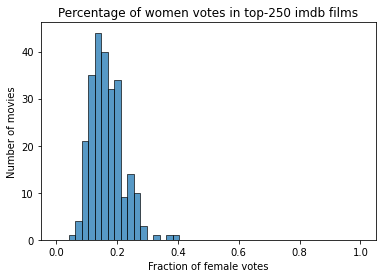

In [154]:
sns.histplot(df_votes['percent_women'], binrange = (0,1))
plt.title('Percentage of women votes in top-250 imdb films')
plt.xlabel('Fraction of female votes')
plt.ylabel('Number of movies')

That is unexpected, we have no film in those 250 best graded which have more than 50% votes coming from women!

In [159]:
print("The mean percentage of women ratings in the 250 imdb top movies is :" + str(round(df_votes['percent_women'].mean()*100,2)) + " percent")

The mean percentage of women ratings in the 250 imdb top movies is :16.69 percent


With such a small amount of ratings coming from women, we can already think that imdb top graded movies showcases male opinion mostly. Why? Hypothesis could be that men are more prompt to use the platform to leave ratings, or that they give better grades on average.

## Bottom 100 movies

In [165]:
bottom_100 = ia.get_bottom100_movies()

df = pd.DataFrame()
ids = []
for movie_count in trange(0, 100):
    # First, retrieve the movie object using its ID
    movie = ia.get_movie(bottom_100[movie_count].movieID, 'vote details')
    a = pd.DataFrame.from_dict(movie.get('demographics'))
    movie = ia.get_movie(bottom_100[movie_count].movieID) # The identifier is simply tconst without "tt"
    ids.append(str(movie.get('title')) + " votes")
    ids.append(str(movie.get('title')) + " ratings")
    
    df = df.append(a)

  0%|          | 0/100 [00:00<?, ?it/s]

100


Text(0, 0.5, 'Number of movies')

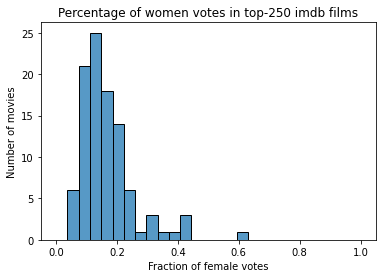

In [166]:
df = df.set_index(np.array(ids))
df_votes = df[df['ttrt fltr imdb users']>10]
print(len(df_votes))
df_votes['percent_women'] = df_votes['ttrt fltr females']/( df_votes['ttrt fltr males'] +  df_votes['ttrt fltr females'])

sns.histplot(df_votes['percent_women'], binrange = (0,1))
plt.title('Percentage of women votes in top-250 imdb films')
plt.xlabel('Fraction of female votes')
plt.ylabel('Number of movies')

Again! Only one movie out of the 100 worst graded movies has more than 50% votes from womens.

In [168]:
m50 = df_votes[df_votes['percent_women'] > 0.5]
m50.head()

,ttrt fltr imdb users,ttrt fltr aged under 18,ttrt fltr aged 18 29,ttrt fltr aged 30 44,ttrt fltr aged 45 plus,ttrt fltr males,ttrt fltr males aged under 18,ttrt fltr males aged 18 29,ttrt fltr males aged 30 44,ttrt fltr males aged 45 plus,ttrt fltr females,ttrt fltr females aged under 18,ttrt fltr females aged 18 29,ttrt fltr females aged 30 44,ttrt fltr females aged 45 plus,ttrt fltr top 1000 voters,ttrt fltr us users,ttrt fltr non us users,percent_women
Bratz votes,23880.0,8.0,3821.0,13729.0,1560.0,7665.0,2.0,919.0,5390.0,1203.0,11814.0,6.0,2808.0,8284.0,332.0,172.0,10774.0,10810.0,0.606499


In [172]:
print(ia.search_movie('bratz'))

[<Movie id:0804452[http] title:_Bratz (2007)_>, <Movie id:0471990[http] title:_"Bratz" (2005)_>, <Movie id:5101204[http] title:_"Bratz" (2015)_>, <Movie id:0417503[http] title:_Bratz: Passion 4 Fashion - Diamondz (2006) (V)_>, <Movie id:11696948[http] title:_Bratz: Rock Angelz (2005) (TV)_>, <Movie id:2330312[http] title:_Bratz Fashion Pixiez (2007) (V)_>, <Movie id:0860833[http] title:_Bratz: Babyz the Movie (2006) (V)_>, <Movie id:1469259[http] title:_Bratz the Video: Starrin' & Stylin' (2004) (V)_>, <Movie id:16023608[http] title:_"Talking Bratz" (2021)_>, <Movie id:0406598[http] title:_Bratz (2002) (VG)_>, <Movie id:3642592[http] title:_"Shameful Sequels" Bratz (2014)_>, <Movie id:1872606[http] title:_"The Nostalgia Chick" Bratz (2009)_>, <Movie id:2882912[http] title:_Bratz Girlz Really Rock (2008)_>, <Movie id:3251832[http] title:_Bratz: Genie Magic (2006) (V)_>, <Movie id:0492571[http] title:_Bratz Rock Angelz (2005) (VG)_>, <Movie id:1650819[http] title:_Bratz Kidz Fairy Tales 

In [180]:
bratz = ia.get_movie('0804452')
print(bratz.get('plot')) 

['During their first year of high school, four best girlfriends face off against the domineering student body President, who wants to split them up into different social cliques.', 'Four best friends start high school. Each one is unique and likes their own thing; Chloe joins the soccer team, Sasha joins the cheer leading squad, Jade is part of the math club. While the other girls hang out with their chosen crowds, Yasmin is left all alone. When Meredith, the most popular girl, sees this she automatically knows they are trouble. After years of not talking to each other Jade and Yasmin speak a few words in the restroom but Yasmin doesn\'t have the courage to tell Jade she misses her. The four girls are reunited when they are sent to detention for causing a food fight. The reunited foursome find out they are not invited to a huge party given by Meredith. Worse, Chloe finds out that her mom has a job serving food at the party. They are forced to work for Meredith. At the party, Meredith d

It's a teenage movie (how bizarre ?).

In [183]:
df_ratings = df[df['ttrt fltr imdb users']<11]
df_ratings.head(5)

,ttrt fltr imdb users,ttrt fltr aged under 18,ttrt fltr aged 18 29,ttrt fltr aged 30 44,ttrt fltr aged 45 plus,ttrt fltr males,ttrt fltr males aged under 18,ttrt fltr males aged 18 29,ttrt fltr males aged 30 44,ttrt fltr males aged 45 plus,ttrt fltr females,ttrt fltr females aged under 18,ttrt fltr females aged 18 29,ttrt fltr females aged 30 44,ttrt fltr females aged 45 plus,ttrt fltr top 1000 voters,ttrt fltr us users,ttrt fltr non us users
Disaster Movie ratings,1.9,1.5,2.0,1.8,2.0,1.8,1.5,2.0,1.8,1.9,2.1,1.3,2.4,2.0,2.1,2.1,1.7,1.9
Manos: The Hands of Fate ratings,1.6,1.3,1.7,1.6,1.6,1.6,1.2,1.7,1.6,1.5,1.8,1.7,2.1,1.7,1.8,1.7,1.5,1.7
Birdemic: Shock and Terror ratings,1.7,1.8,1.6,1.7,1.6,1.7,1.2,1.6,1.7,1.6,1.7,2.4,1.8,1.7,1.7,1.6,1.8,1.6
Superbabies: Baby Geniuses 2 ratings,1.5,1.3,1.5,1.4,1.6,1.4,1.3,1.4,1.3,1.6,2.1,2.5,2.1,2.0,2.4,1.9,1.4,1.5
The Hottie & the Nottie ratings,1.9,1.0,2.1,1.9,1.9,1.9,1.0,2.0,1.9,2.0,2.2,NaN,2.4,2.1,1.9,2.5,1.7,2.0


In [184]:
df_ratings.describe()

,ttrt fltr imdb users,ttrt fltr aged under 18,ttrt fltr aged 18 29,ttrt fltr aged 30 44,ttrt fltr aged 45 plus,ttrt fltr males,ttrt fltr males aged under 18,ttrt fltr males aged 18 29,ttrt fltr males aged 30 44,ttrt fltr males aged 45 plus,ttrt fltr females,ttrt fltr females aged under 18,ttrt fltr females aged 18 29,ttrt fltr females aged 30 44,ttrt fltr females aged 45 plus,ttrt fltr top 1000 voters,ttrt fltr us users,ttrt fltr non us users
count,100.000000,100.0000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,86.000000,100.0000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.891000,2.7200,2.881000,2.838000,3.03900,2.821000,2.575000,2.770000,2.786000,3.008000,3.271000,3.113953,3.4390,3.189000,3.397000,2.936000,2.879000,2.896000
std,0.737878,1.2762,0.805749,0.757292,0.73442,0.737905,1.425339,0.764159,0.749683,0.730252,0.835488,1.781352,0.9689,0.835197,0.838283,0.609772,0.754688,0.743174
min,1.200000,1.0000,1.100000,1.100000,1.20000,1.200000,1.000000,1.100000,1.100000,1.200000,1.100000,1.000000,1.0000,1.100000,1.300000,1.400000,1.300000,1.100000
25%,2.400000,1.8000,2.400000,2.300000,2.57500,2.275000,1.500000,2.175000,2.300000,2.500000,2.850000,1.925000,2.9000,2.675000,2.900000,2.500000,2.300000,2.400000
50%,3.100000,2.4000,2.950000,3.100000,3.10000,3.000000,2.250000,2.850000,3.000000,3.100000,3.500000,2.700000,3.6000,3.400000,3.600000,3.050000,3.000000,3.100000
75%,3.500000,3.4250,3.500000,3.425000,3.62500,3.400000,3.425000,3.400000,3.400000,3.600000,3.900000,4.000000,4.2000,3.725000,4.000000,3.400000,3.500000,3.500000
max,3.900000,6.7000,4.800000,3.900000,4.20000,3.900000,7.000000,4.200000,3.900000,4.200000,5.000000,8.200000,5.7000,5.000000,5.000000,4.000000,4.100000,4.000000


On the bottom 100 movies, we see that women have given on average higher grades than men (respectively 3.27 and 2.82).

This was just a quick analysis to see what we could find, but for the final project, we intend to investigate these informations for more movies, according to genres and countries for example. We keep in mind that there seem to have much more men ratings on Imdb than women ratings. This is quite unexpected and lead to think that the appreciation of movies in this platform is mostly defined by how much men like this content.

# Merging of IMDB and CMU datasets

In [112]:
fb_to_wiki = pd.read_csv('freebase_to_imdb.csv')
fb_to_wiki.drop(columns = ['sitelink', 'item'], inplace = True)
fb_to_wiki

,freebaseID,IMDb_ID
0,/m/0gmgwnv,tt0443272
1,/m/03qlwpd,tt1157609
2,/m/04cvqhb,tt1161022
3,/m/04jhzrd,tt0061916
4,/m/02vlqgl,tt0063010
...,...,...
102803,/m/0gm160t,tt1117379
102804,/m/0_vxtn2,tt1298640
102805,/m/0jkwsv6,tt2099556
102806,/m/0sxdlhk,tt2396701


In [113]:
data = cmu_movie_metadata.merge(fb_to_wiki, how = 'inner', left_on = 'Freebase movie ID', right_on = 'freebaseID' )

In [114]:
merged_cmu_wiki = data.merge(df_title_basics, how = 'inner', left_on = 'IMDb_ID', right_on = 'tconst')
merged_cmu_wiki

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,freebaseID,IMDb_ID,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",/m/03vyhn,tt0228333,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi"
1,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",/m/0crgdbh,tt0094806,tt0094806,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama"
2,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",/m/0285_cd,tt0094320,tt0094320,movie,White of the Eye,White of the Eye,0,1987,\N,110,"Horror,Thriller"
3,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",/m/01mrr1,tt0083949,tt0083949,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama
4,/m/02qc0j7,Alexander's Ragtime Band,1938.0,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",/m/02qc0j7,tt0029852,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,0,1938,\N,106,"Drama,Music,Musical"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61939,/m/06_vb43,The Ghost Train,1941.0,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",/m/06_vb43,tt0033660,tt0033660,movie,The Ghost Train,The Ghost Train,0,1941,\N,85,"Comedy,Horror"
61940,/m/0crwd9y,Shadow Boxing 2,2007.0,NaN,132.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/06bnz"": ""Russia""}","{""/m/01z02hx"": ""Sports"", ""/m/0lsxr"": ""Crime Fi...",/m/0crwd9y,tt0459759,tt0459759,movie,Revenge,Boy s tenyu II. Revansh,0,2007,\N,135,"Action,Crime,Drama"
61941,/m/0g4pl34,Knuckle,2011.0,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",/m/0g4pl34,tt1606259,tt1606259,movie,Knuckle,Knuckle,0,2011,\N,97,"Biography,Documentary,Drama"
61942,/m/02pygw1,Another Nice Mess,1972.0,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",/m/02pygw1,tt0362411,tt0362411,movie,Another Nice Mess,Another Nice Mess,0,1972,\N,66,Comedy


We have been able to map 62 000 movies out of 81 000 between imdb and freebase. 

In [115]:
merged_cmu_wiki = merged_cmu_wiki.merge(df_crew, how = 'inner', left_on = 'IMDb_ID', right_on = 'tconst')

In [116]:
merged_cmu_wiki

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,freebaseID,IMDb_ID,...,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,tconst_y,directors,writers
0,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",/m/03vyhn,tt0228333,...,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",tt0228333,nm0000118,"nm0837917,nm0000118"
1,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",/m/0crgdbh,tt0094806,...,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",tt0094806,nm0803751,"nm0803751,nm0820866"
2,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",/m/0285_cd,tt0094320,...,White of the Eye,White of the Eye,0,1987,\N,110,"Horror,Thriller",tt0094320,nm0131910,"nm0465026,nm0131910,nm0458461,nm1738738"
3,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",/m/01mrr1,tt0083949,...,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,tt0083949,nm0885554,"nm0885554,nm0959016"
4,/m/02qc0j7,Alexander's Ragtime Band,1938.0,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",/m/02qc0j7,tt0029852,...,Alexander's Ragtime Band,Alexander's Ragtime Band,0,1938,\N,106,"Drama,Music,Musical",tt0029852,nm0454771,"nm0778636,nm0873707,nm0792553,nm0000927,nm0316..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61939,/m/06_vb43,The Ghost Train,1941.0,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",/m/06_vb43,tt0033660,...,The Ghost Train,The Ghost Train,0,1941,\N,85,"Comedy,Horror",tt0033660,nm0285962,"nm0725965,nm0651357,nm0346436,nm0249218"
61940,/m/0crwd9y,Shadow Boxing 2,2007.0,NaN,132.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/06bnz"": ""Russia""}","{""/m/01z02hx"": ""Sports"", ""/m/0lsxr"": ""Crime Fi...",/m/0crwd9y,tt0459759,...,Revenge,Boy s tenyu II. Revansh,0,2007,\N,135,"Action,Crime,Drama",tt0459759,nm2415918,"nm1284414,nm12760099"
61941,/m/0g4pl34,Knuckle,2011.0,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",/m/0g4pl34,tt1606259,...,Knuckle,Knuckle,0,2011,\N,97,"Biography,Documentary,Drama",tt1606259,nm3817974,\N
61942,/m/02pygw1,Another Nice Mess,1972.0,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",/m/02pygw1,tt0362411,...,Another Nice Mess,Another Nice Mess,0,1972,\N,66,Comedy,tt0362411,nm0251872,nm0251872


In [117]:
df_directors = merged_cmu_wiki[['Freebase movie ID', 'directors']]
df_directors

,Freebase movie ID,directors
0,/m/03vyhn,nm0000118
1,/m/0crgdbh,nm0803751
2,/m/0285_cd,nm0131910
3,/m/01mrr1,nm0885554
4,/m/02qc0j7,nm0454771
...,...,...
61939,/m/06_vb43,nm0285962
61940,/m/0crwd9y,nm2415918
61941,/m/0g4pl34,nm3817974
61942,/m/02pygw1,nm0251872


In [118]:
df_writers = merged_cmu_wiki[['Freebase movie ID', 'writers']]
df_writers

,Freebase movie ID,writers
0,/m/03vyhn,"nm0837917,nm0000118"
1,/m/0crgdbh,"nm0803751,nm0820866"
2,/m/0285_cd,"nm0465026,nm0131910,nm0458461,nm1738738"
3,/m/01mrr1,"nm0885554,nm0959016"
4,/m/02qc0j7,"nm0778636,nm0873707,nm0792553,nm0000927,nm0316..."
...,...,...
61939,/m/06_vb43,"nm0725965,nm0651357,nm0346436,nm0249218"
61940,/m/0crwd9y,"nm1284414,nm12760099"
61941,/m/0g4pl34,\N
61942,/m/02pygw1,nm0251872


In [119]:
df_writers['writers'] = df_writers['writers'].apply(lambda x : x.split(','))

In [120]:
df_directors['directors'] = df_directors['directors'].apply(lambda x : x.split(','))

In [121]:
gender_imdb = pd.read_csv('imdb_genders.csv')
gender_imdb['gender'] = gender_imdb['gender'].apply(lambda x : str(x).rsplit('/', 1)[-1])
gender_imdb = gender_imdb.drop(columns = ['id'])
gender_imdb.head(5)

,gender,IMDb_ID
0,Q6581097,nm0899581
1,Q6581097,nm2561320
2,Q6581097,nm0005240
3,Q6581097,nm0707199
4,Q6581097,nm1211443


In [122]:
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581097', 'male')
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581072', 'female')
gender_imdb = gender_imdb[gender_imdb['gender'].str.contains('male|female')]

In [123]:
gender_imdb

,gender,IMDb_ID
0,male,nm0899581
1,male,nm2561320
2,male,nm0005240
3,male,nm0707199
4,male,nm1211443
...,...,...
427565,male,nm9786769
427566,female,nm6538741
427567,male,nm0905799
427568,female,nm1479331


In [124]:
df_directors = df_directors.set_index(['Freebase movie ID']).apply(lambda x: x.explode()).reset_index()

In [125]:
df_writers = df_writers.set_index(['Freebase movie ID']).apply(lambda x: x.explode()).reset_index()

In [126]:
df_writers_unique = df_writers.drop_duplicates(subset = 'writers')

In [127]:
df_writers_unique

,Freebase movie ID,writers
0,/m/03vyhn,nm0837917
1,/m/03vyhn,nm0000118
2,/m/0crgdbh,nm0803751
3,/m/0crgdbh,nm0820866
4,/m/0285_cd,nm0465026
...,...,...
133672,/m/0kvgqb,nm0018740
133689,/m/0bbwngb,nm3807650
133695,/m/0crwd9y,nm12760099
133697,/m/02pygw1,nm0251872


In [128]:
df_wri = df_writers_unique.merge(gender_imdb, how = 'inner', left_on='writers', right_on = 'IMDb_ID')

In [129]:
df_directors_unique = df_directors.drop_duplicates(subset = 'directors')

In [130]:
df_dir = df_directors_unique.merge(gender_imdb, how = 'inner', left_on='directors', right_on = 'IMDb_ID')

In [132]:
df_wri['gender'].value_counts()

male      24027
female     3841
Name: gender, dtype: int64

In [134]:
df_dir

,Freebase movie ID,directors,gender,IMDb_ID
0,/m/03vyhn,nm0000118,male,nm0000118
1,/m/0crgdbh,nm0803751,male,nm0803751
2,/m/0285_cd,nm0131910,male,nm0131910
3,/m/01mrr1,nm0885554,male,nm0885554
4,/m/02qc0j7,nm0454771,male,nm0454771
...,...,...,...,...
17220,/m/06_y3t0,nm0214495,male,nm0214495
17221,/m/0gh7dwg,nm0902345,male,nm0902345
17222,/m/03m6zh4,nm0240881,male,nm0240881
17223,/m/0bbwngb,nm1760911,male,nm1760911


In [136]:
df_dir['gender'].value_counts()

male      15568
female     1657
Name: gender, dtype: int64

# DUMP from now (observations/issues)

In [40]:
genre_groups_women = women_ordering.groupby(['genres'])
genre_groups_men = men_ordering.groupby(['genres'])

genre_groups_women = genre_groups_women.apply(lambda x: pd.Series({
    'mean order' : x['ordering'].mean(),
    'lower_err_order': bootstrap_CI(x['ordering'], 10000)[0],
    'upper_err_order': bootstrap_CI(x['ordering'], 10000)[1]
}))

genre_groups_men = genre_groups_men.apply(lambda x: pd.Series({
    'mean order' : x['ordering'].mean(),
    'lower_err_order': bootstrap_CI(x['ordering'], 10000)[0],
    'upper_err_order': bootstrap_CI(x['ordering'], 10000)[1]
}))

<BarContainer object of 1274 artists>

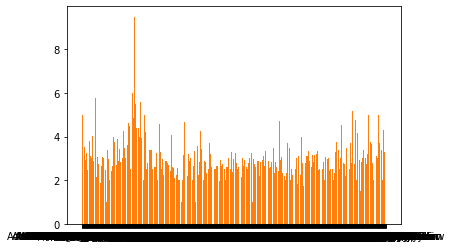

In [42]:
plt.bar(genre_groups_men.index, genre_groups_men['mean order'])
plt.bar(genre_groups_men.index, genre_groups_men['mean order'])

 *IT IS HARD TO JOIN THE DATA, MANY MOVIES HAVE THE SAME NAME, NOT THAT MANY MATCH !*

In [ ]:
df_linked = cmu_movie_metadata.merge(final_df, how = 'inner',left_on = 'Movie name', right_on = 'primaryName')

In [ ]:
df_linked.head(5)

In [ ]:
len(df_linked)

In [ ]:
len(df_linked.drop_duplicates(subset = 'Movie name'))

In [ ]:
len(cmu_movie_metadata)

## 2. Cleaning and cooking the data

## 3. Merging IMDb and CMU datasets

In [6]:
cmu_movie_metadata

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"


In [20]:
final_df

,tconst,ordering,nconst,category,characters,primaryName,primaryTitle,startYear,runtimeMinutes,genres
5,tt0000009,1,nm0063086,actress,"[""Miss Geraldine Holbrook (Miss Jerry)""]",Blanche Bayliss,Miss Jerry,1894,45,Romance
6,tt0000009,2,nm0183823,actor,"[""Mr. Hamilton""]",William Courtenay,Miss Jerry,1894,45,Romance
7,tt0000009,3,nm1309758,actor,"[""Chauncey Depew - the Director of the New Yor...",Chauncey Depew,Miss Jerry,1894,45,Romance
231,tt0000502,1,nm0215752,actor,\N,Antonio del Pozo,Bohemios,1905,100,\N
232,tt0000502,2,nm0252720,actor,\N,El Mochuelo,Bohemios,1905,100,\N
...,...,...,...,...,...,...,...,...,...,...
20721760,tt9916706,4,nm3272130,actress,\N,Ashwini Ekbote,Dankyavar Danka,2013,\N,Comedy
20721768,tt9916730,1,nm6096005,actor,\N,Devadhar Archit,6 Gunn,2017,116,\N
20721769,tt9916730,2,nm0059461,actor,\N,Sunil Barve,6 Gunn,2017,116,\N
20721770,tt9916730,3,nm13233318,actor,"[""Vishal""]",Ganesh Vasant Patil,6 Gunn,2017,116,\N


In [21]:
imdb_to_wiki = pd.read_csv('imdb_to_wikipedia.csv')
imdb_to_wiki['item'] = imdb_to_wiki['item'].apply(lambda x : x.rsplit('/', 1)[-1])
imdb_to_wiki.head()
imdb_to_wiki.drop(columns = ['sitelink'], inplace = True)
imdb_to_wiki['item'] = imdb_to_wiki['item'].apply(lambda x : x.rsplit('Q', 1)[-1])
imdb_to_wiki

,item,IMDb_ID
0,24515,tt1533749
1,24585,tt0024480
2,24618,tt0116675
3,24732,tt0005005
4,24815,tt0033467
...,...,...
216068,114877272,tt6231588
216069,114878014,tt7544218
216070,114885544,tt15100778
216071,114887327,tt0332064


In [32]:
final_df.merge(imdb_to_wiki, how = 'inner', left_on = 'tconst', right_on = 'IMDb_ID' )

,tconst,ordering,nconst,category,characters,primaryName,primaryTitle,startYear,runtimeMinutes,genres,item,IMDb_ID
0,tt0000591,1,nm0906197,actor,\N,Georges Wague,The Prodigal Son,1907,90,Drama,3203051,tt0000591
1,tt0000591,2,nm0332182,actor,\N,Henri Gouget,The Prodigal Son,1907,90,Drama,3203051,tt0000591
2,tt0000591,3,nm1323543,actress,\N,Christiane Mandelys,The Prodigal Son,1907,90,Drama,3203051,tt0000591
3,tt0000591,4,nm1759558,actress,\N,Gilberte Sergy,The Prodigal Son,1907,90,Drama,3203051,tt0000591
4,tt0000615,1,nm3071427,actor,"[""Warrigal""]",Jim Gerald,Robbery Under Arms,1907,\N,Drama,7340830,tt0000615
...,...,...,...,...,...,...,...,...,...,...,...,...
760253,tt9916428,2,nm9445072,actor,"[""Mao Ze Dong""]",Wang Peng Kai,The Secret of China,2019,\N,"Adventure,History,War",65946287,tt9916428
760254,tt9916428,3,nm8594703,actor,"[""Dr. Hatem""]",Valery Gadreau,The Secret of China,2019,\N,"Adventure,History,War",65946287,tt9916428
760255,tt9916428,4,nm0422639,actress,"[""Song Qingling""]",Wenli Jiang,The Secret of China,2019,\N,"Adventure,History,War",65946287,tt9916428
760256,tt9916428,6,nm8680851,actor,"[""Powell Editor-in-chief of US newspaper""]",Vincent Matile,The Secret of China,2019,\N,"Adventure,History,War",65946287,tt9916428


New attempt